In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV

data_df_clean = data_df.dropna(subset=['quasisymmetry'])

X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = data_df_clean[['quasisymmetry', 'quasiisodynamic', 'rotational_transform', 'inverse_aspect_ratio', 'mean_local_magnetic_shear', 'vacuum_magnetic_well', 'maximum_elongation', 'mirror_ratio']]

target = Y['quasisymmetry']
features = X

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(features.shape)
print(target.shape)


(308466, 8)
(308466,)


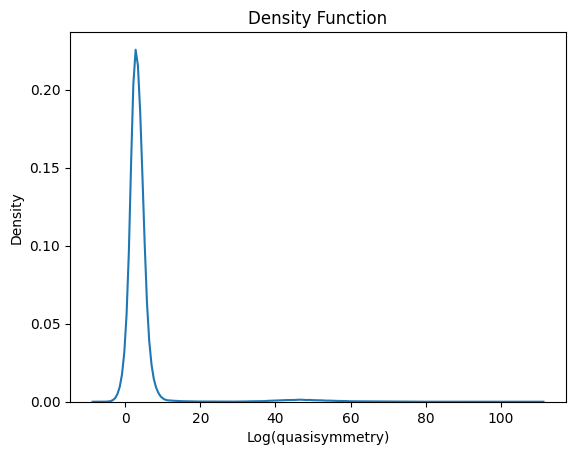

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.kdeplot(np.log(target), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()


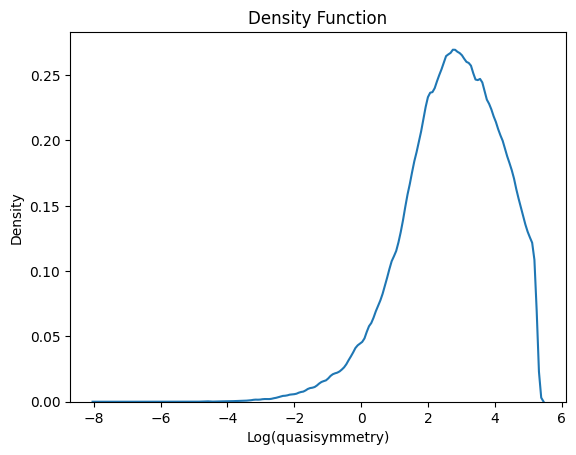

In [5]:
# now i want to eliminate the outliers

q1 = target.quantile(0.25)
q3 = target.quantile(0.75)

# Calculate the interquartile range (IQR)
iqr = q3 - q1

# Define bounds for what is considered an outlier
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the data to remove outliers
target_no_outliers = Y_train[(Y_train >= lower_bound) & (Y_train <= upper_bound)]
features_no_outliers = X_train.loc[target_no_outliers.index]

test_target_no_outliers = Y_test[(Y_test >= lower_bound) & (Y_test <= upper_bound)]
test_features_no_outliers = X_test.loc[test_target_no_outliers.index.intersection(X_test.index)]

sns.kdeplot(np.log(target_no_outliers), bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()

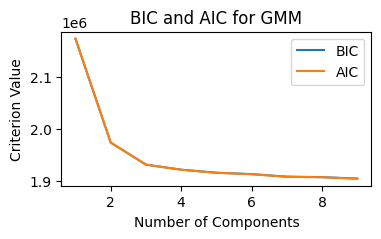

Selected Model Components: 9


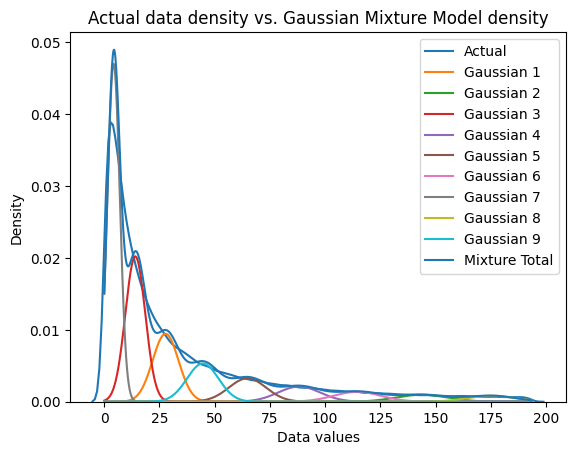

In [6]:
from sklearn.mixture import GaussianMixture

from scipy.stats import norm



# Assuming `Y_train_np` is your 1D numpy array data
target_no_outliers_np = target_no_outliers.to_numpy().reshape(-1, 1)  # Reshape to 2D if necessary

# Use AIC and BIC to determine the best number of components for GMM
n_components_range = range(1, 10)  # Example range, can be adjusted
lowest_bic = np.infty
lowest_aic = np.infty
best_gmm = None
bic = []
aic = []

for n_components in n_components_range:
    # Fit a Gaussian mixture with n components
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(target_no_outliers_np)
    
    # Calculate the BIC and AIC
    bic.append(gmm.bic(target_no_outliers_np))
    aic.append(gmm.aic(target_no_outliers_np))
    
    # Determine if this model has the lowest BIC
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm_bic = gmm
        
    # Determine if this model has the lowest AIC
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_gmm_aic = gmm

# Plot the BIC scores
plt.figure(figsize=(4, 2))
plt.plot(n_components_range, bic, label='BIC')
plt.plot(n_components_range, aic, label='AIC')
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Criterion Value')
plt.title('BIC and AIC for GMM')
plt.show()

# Use the best model for the final density plot
best_gmm = best_gmm_bic if lowest_bic < lowest_aic else best_gmm_aic
print(f"Selected Model Components: {best_gmm.n_components}")

# Generate some data points for plotting the density
x = np.linspace(target_no_outliers_np.min(), target_no_outliers_np.max(), 1000).reshape(-1, 1)
logprob = best_gmm.score_samples(x)
responsibilities = best_gmm.predict_proba(x)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

# Plot the actual kernel density estimation of your data
sns.kdeplot(target_no_outliers_np.flatten(), bw_adjust=0.5, label='Actual')

# Plot each component density
for i in range(best_gmm.n_components):
    plt.plot(x, pdf_individual[:, i], label=f'Gaussian {i+1}')

# Plot the total density
plt.plot(x, pdf, label='Mixture Total')

plt.legend()
plt.title('Actual data density vs. Gaussian Mixture Model density')
plt.xlabel('Data values')
plt.ylabel('Density')
plt.show()


/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:18<00:00,  2.25s/it]


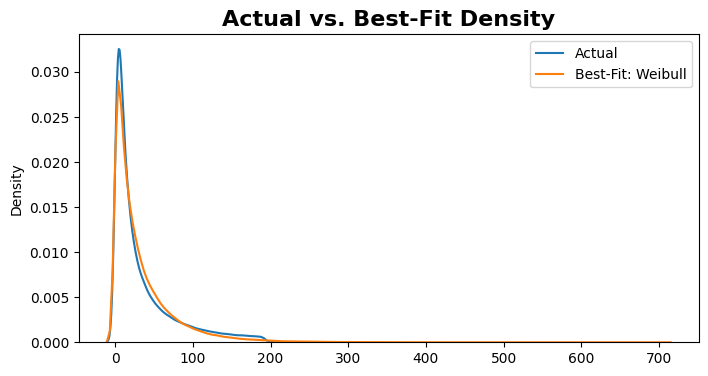

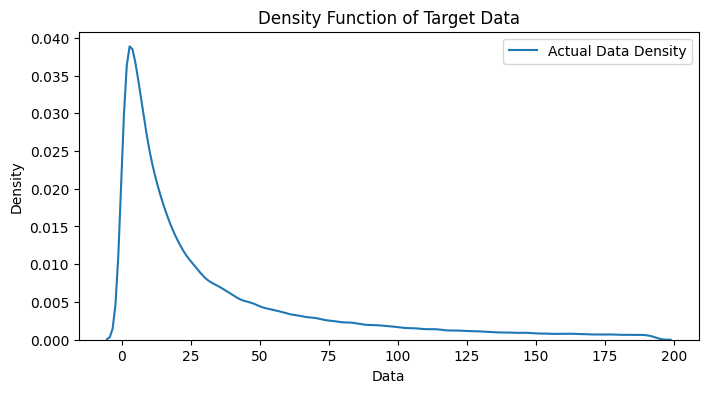

In [7]:
from lightgbmlss.distributions import *
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your data preparation steps
target_no_outliers_np = np.array(target_no_outliers)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace]

# Selecting the best distribution based on negative log-likelihood
dist_nll = lgblss_dist_class.dist_select(target=target_no_outliers_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
dist_nll

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(target_no_outliers_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()


In [8]:
# from scipy import stats
# import matplotlib.pyplot as plt

# # Assuming Y_train_np is your data
# distributions = {
#     'norm': stats.norm, 
#     't': stats.t, 
#     'gamma': stats.gamma, 
#     'cauchy': stats.cauchy, 
#     'lognorm': stats.lognorm,
# }

# for name, dist in distributions.items():
#     # Fit the distribution to your data
#     params = dist.fit()
    
#     # Generate Q-Q plot
#     plt.figure(figsize=(7, 4))
#     stats.probplot(Y_train_np, dist=name, sparams=params[:-2], plot=plt)
#     plt.title(f'Q-Q Plot for {name.capitalize()} Distribution')
#     plt.show()
# Select the first 1000 samples from X_train and their corresponding labels
X_train_subset = features_no_outliers # Ver quantis
Y_train_subset = target_no_outliers

print(X_train_subset.shape)


(211779, 8)


este grafico apenas ve a distribuição da target variable?

In [10]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Weibull import *
import lightgbm as lgb
import numpy as np



# Create the Dataset with max_bin parameter specified
dtrain = lgb.Dataset(X_train_subset, label=Y_train_subset.values, params={'max_bin': 500})

# Initialize the LightGBMLSS model with the Weibull distribution
lgblss = LightGBMLSS(
    Weibull(stabilization="None", response_fn="exp", loss_fn="nll")
)

# Define the parameter dictionary without max_bin
param_dict = {
    "max_depth": ["int", {"low": 1, "high": 25, "log": False}],
    "num_leaves": ["int", {"low": 2, "high": 100, "log": True}],
    "min_data_in_leaf": ["int", {"low": 20, "high": 500, "log": False}],
    "min_gain_to_split": ["float", {"low": 0.01, "high": 40, "log": True}],
    "min_sum_hessian_in_leaf": ["float", {"low": 0.01, "high": 100, "log": True}],
    "subsample": ["float", {"low": 0.5, "high": 1.0, "log": False}],
    "subsample_freq": ["int", {"low": 1, "high": 20, "log": False}],
    "feature_fraction": ["float", {"low": 0.3, "high": 1.0, "log": False}],
    "boosting_type": ["categorical", ["dart", "goss", "gbdt"]],
    "learning_rate": ["float", {"low": 0.1, "high": 0.2, "log": True}],
    # "lambda_l1" and "lambda_l2" are commented out as before
    "max_delta_step": ["float", {"low": 0, "high": 1, "log": False}],
    "num_boost_round": ["int", {"low": 5, "high": 1000, "log": True}],
    "feature_pre_filter": ["categorical", [False]],
    "boosting": ["categorical", ["dart"]]
}

# Set a seed for reproducibility
np.random.seed(123)

# Perform hyperparameter optimization
opt_param = lgblss.hyper_opt(
    param_dict,
    dtrain,
    #num_boost_round=30,
    nfold=5,
    early_stopping_rounds=100,
    max_minutes=60,
    n_trials=300,
    silence=False,
    seed=13,
    hp_seed=123
)


[I 2024-04-24 20:22:07,310] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization
Best trial: 0. Best value: 188588:   0%|          | 1/300 [00:06<30:34,  6.14s/it, 6.13/3600 seconds]

[I 2024-04-24 20:22:13,444] Trial 0 finished with value: 188588.10087712444 and parameters: {'max_depth': 18, 'num_leaves': 5, 'min_data_in_leaf': 129, 'min_gain_to_split': 0.967985545750277, 'min_sum_hessian_in_leaf': 7.548764540205035, 'subsample': 0.7115532300622305, 'subsample_freq': 20, 'feature_fraction': 0.7793808170094043, 'boosting_type': 'dart', 'learning_rate': 0.16575469179973, 'max_delta_step': 0.4385722446796244, 'num_boost_round': 6, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 0 with value: 188588.10087712444.


Best trial: 1. Best value: 186301:   1%|          | 2/300 [00:11<28:34,  5.75s/it, 11.62/3600 seconds]

[I 2024-04-24 20:22:18,930] Trial 1 finished with value: 186300.65627600029 and parameters: {'max_depth': 10, 'num_leaves': 33, 'min_data_in_leaf': 107, 'min_gain_to_split': 0.042853643385318635, 'min_sum_hessian_in_leaf': 1.3372281038573093, 'subsample': 0.765913793548433, 'subsample_freq': 13, 'feature_fraction': 0.8946022558544526, 'boosting_type': 'dart', 'learning_rate': 0.12508934557279636, 'max_delta_step': 0.3617886556223141, 'num_boost_round': 15, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 186300.65627600029.


Best trial: 1. Best value: 186301:   1%|          | 3/300 [00:14<22:40,  4.58s/it, 14.81/3600 seconds]

[I 2024-04-24 20:22:22,119] Trial 2 finished with value: 188308.3597977804 and parameters: {'max_depth': 8, 'num_leaves': 21, 'min_data_in_leaf': 64, 'min_gain_to_split': 0.36493678549860337, 'min_sum_hessian_in_leaf': 0.5289943741212555, 'subsample': 0.7468425488251531, 'subsample_freq': 9, 'feature_fraction': 0.5185828560807257, 'boosting_type': 'gbdt', 'learning_rate': 0.1416015125395276, 'max_delta_step': 0.6239529517921112, 'num_boost_round': 8, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 186300.65627600029.


Best trial: 1. Best value: 186301:   1%|▏         | 4/300 [00:23<30:02,  6.09s/it, 23.21/3600 seconds]

[I 2024-04-24 20:22:30,522] Trial 3 finished with value: 186410.94827861473 and parameters: {'max_depth': 8, 'num_leaves': 9, 'min_data_in_leaf': 436, 'min_gain_to_split': 0.07982800048829394, 'min_sum_hessian_in_leaf': 0.8553366021440332, 'subsample': 0.9927798928053525, 'subsample_freq': 11, 'feature_fraction': 0.7290261680340773, 'boosting_type': 'goss', 'learning_rate': 0.14590891218778215, 'max_delta_step': 0.3427638337743084, 'num_boost_round': 23, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 1 with value: 186300.65627600029.


Best trial: 4. Best value: 183668:   2%|▏         | 5/300 [01:01<1:27:42, 17.84s/it, 61.88/3600 seconds]

[I 2024-04-24 20:23:09,195] Trial 4 finished with value: 183668.3721708355 and parameters: {'max_depth': 11, 'num_leaves': 26, 'min_data_in_leaf': 441, 'min_gain_to_split': 0.6895597134374053, 'min_sum_hessian_in_leaf': 4.75614549740129, 'subsample': 0.7929682762811064, 'subsample_freq': 13, 'feature_fraction': 0.7722823356914774, 'boosting_type': 'dart', 'learning_rate': 0.11839977788721733, 'max_delta_step': 0.19422296057877086, 'num_boost_round': 99, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 4 with value: 183668.3721708355.


Best trial: 4. Best value: 183668:   2%|▏         | 6/300 [01:13<1:16:50, 15.68s/it, 73.37/3600 seconds]

[I 2024-04-24 20:23:20,682] Trial 5 finished with value: 186759.92515228657 and parameters: {'max_depth': 3, 'num_leaves': 62, 'min_data_in_leaf': 321, 'min_gain_to_split': 4.034494436407351, 'min_sum_hessian_in_leaf': 0.011601571656744782, 'subsample': 0.7972159397225212, 'subsample_freq': 12, 'feature_fraction': 0.4112717509013059, 'boosting_type': 'goss', 'learning_rate': 0.1615488292670135, 'max_delta_step': 0.5543832497177721, 'num_boost_round': 37, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 4 with value: 183668.3721708355.


Best trial: 4. Best value: 183668:   2%|▏         | 7/300 [01:27<1:13:19, 15.01s/it, 87.02/3600 seconds]

[I 2024-04-24 20:23:34,327] Trial 6 finished with value: 183933.971500943 and parameters: {'max_depth': 24, 'num_leaves': 52, 'min_data_in_leaf': 191, 'min_gain_to_split': 0.014355524599494554, 'min_sum_hessian_in_leaf': 0.16560456096344592, 'subsample': 0.6990928409589905, 'subsample_freq': 15, 'feature_fraction': 0.9967509374238122, 'boosting_type': 'goss', 'learning_rate': 0.16151876656381636, 'max_delta_step': 0.15112745234808023, 'num_boost_round': 39, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 4 with value: 183668.3721708355.


Best trial: 4. Best value: 183668:   3%|▎         | 8/300 [01:36<1:05:06, 13.38s/it, 96.90/3600 seconds]

[I 2024-04-24 20:23:44,206] Trial 7 finished with value: 186933.2235038686 and parameters: {'max_depth': 7, 'num_leaves': 6, 'min_data_in_leaf': 266, 'min_gain_to_split': 2.5189620314317227, 'min_sum_hessian_in_leaf': 0.02652368980737461, 'subsample': 0.5654474753320404, 'subsample_freq': 7, 'feature_fraction': 0.7630950356663706, 'boosting_type': 'gbdt', 'learning_rate': 0.13057129897254843, 'max_delta_step': 0.31678789711837974, 'num_boost_round': 31, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 4 with value: 183668.3721708355.


Best trial: 8. Best value: 176639:   3%|▎         | 9/300 [13:12<18:19:28, 226.69s/it, 792.63/3600 seconds]

[I 2024-04-24 20:35:19,940] Trial 8 finished with value: 176638.80414902788 and parameters: {'max_depth': 5, 'num_leaves': 49, 'min_data_in_leaf': 182, 'min_gain_to_split': 0.9764952804631334, 'min_sum_hessian_in_leaf': 2.061606963364211, 'subsample': 0.7607665296986661, 'subsample_freq': 1, 'feature_fraction': 0.991841793497974, 'boosting_type': 'dart', 'learning_rate': 0.14339653396168858, 'max_delta_step': 0.9019113726606706, 'num_boost_round': 916, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 8 with value: 176638.80414902788.


Best trial: 8. Best value: 176639:   3%|▎         | 10/300 [13:42<13:21:23, 165.81s/it, 822.10/3600 seconds]

[I 2024-04-24 20:35:49,405] Trial 9 finished with value: 184072.38411072717 and parameters: {'max_depth': 7, 'num_leaves': 16, 'min_data_in_leaf': 408, 'min_gain_to_split': 0.2633568343157822, 'min_sum_hessian_in_leaf': 8.400248686226801, 'subsample': 0.5805345072146074, 'subsample_freq': 13, 'feature_fraction': 0.9061051208122852, 'boosting_type': 'dart', 'learning_rate': 0.11523211579898833, 'max_delta_step': 0.4506364905187348, 'num_boost_round': 87, 'feature_pre_filter': False, 'boosting': 'dart'}. Best is trial 8 with value: 176638.80414902788.


Best trial: 8. Best value: 176639:   4%|▎         | 11/300 [13:48<9:23:01, 116.89s/it, 828.08/3600 seconds] 

[I 2024-04-24 20:35:55,390] Trial 10 pruned. Trial was pruned at iteration 20.


In [ ]:
import numpy as np
import torch
from lightgbmlss.model import LightGBMLSS  # Ensure this import matches your actual usage

# Seed for reproducibility in numpy operations
np.random.seed(123)

# Assuming opt_param is defined somewhere in your code
opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Assuming dtrain is defined and is an appropriate dataset for training
# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Seed for reproducibility in torch operations
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = len(test_target_no_outliers)  # Use the number of rows in X_test as the number of samples

# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95]

# Sample from predicted distribution
pred_samples = lgblss.predict(
    X_test,
    pred_type="samples",
    n_samples=n_samples,
    seed=123
)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(
    X_test,
    pred_type="quantiles",
    n_samples=n_samples,
    quantiles=quant_sel
)

# Return predicted distributional parameters
pred_params = lgblss.predict(
    X_test,
    pred_type="parameters"
)


In [ ]:
df_predictions = pd.DataFrame({
    "Predicted": pred_samples.flatten(),  # Flatten in case the predictions are in a 2D array
    "Type": "Predicted"
})
df_actual = pd.DataFrame({
    "Predicted": np.tile(Y_test, (len(pred_samples) // len(Y_test))),
    "Type": "Actual"
})

# Combine and plot
df_combined = pd.concat([df_predictions, df_actual])
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_combined, x="Predicted", hue="Type", fill=True)
plt.title('Density Plot of Predicted Outputs vs Actual Values')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend(title='Type')
plt.show()

y_sample0   y_sample1  y_sample2  y_sample3  y_sample4   y_sample5  \
0  32.950928   20.511736   3.396253  34.023930  22.863260    6.483053   
1  76.644394  137.300827  46.048725  44.640869   7.880385  130.626511   
2  24.538721    0.503233   9.985978  10.357891   6.378681    4.849741   
3  40.686512   20.571695  15.848892  26.024702  23.298843   16.657280   
4  45.273689   25.219896  14.373977  14.440701  35.889919  122.306595   

   y_sample6  y_sample7  y_sample8  y_sample9  ...  y_sample2990  \
0  13.258399  23.362263  38.729046  16.840357  ...     30.273014   
1  75.047104  12.908735  80.682137  49.302307  ...     34.855377   
2  15.619827   6.536065   9.414264  20.219160  ...     32.420555   
3  17.529575  68.658463  21.000698   7.198605  ...     18.020952   
4  10.655355   3.279119  38.327995   7.183535  ...     45.210754   

   y_sample2991  y_sample2992  y_sample2993  y_sample2994  y_sample2995  \
0     48.976742     32.420006      5.950262     72.706894     31.760752   
1     16.063572     80.388824     74.257568      8.295202      7.716574   
2     10.777445      1.517369      5.877943     15.930542      3.642372   
3      6.466012     12.089483     13.203207     17.370840     22.724726   
4    178.617645     29.807877      0.805867     36.567162      8.753820   

   y_sample2996  y_sample2997  y_sample2998  y_sample2999  
0      1.659684     33.952110     36.567455     96.694466  
1    149.562897     59.630650     31.632839     49.468704  
2     21.566240     14.261162      3.461622      8.905836  
3     11.903275      1.776331     95.098335      5.757203  
4     39.727985      1.662408     52.617664     64.734467  

[5 rows x 3000 columns]

In [ ]:
pred_quantiles.head()

quant_0.05  quant_0.95
0    2.303468   95.991557
1    1.592939  150.919427
2    1.036181   45.893154
3    1.101628   56.042348
4    1.873824  130.981303

In [ ]:
pred_params.head()

scale  concentration
0  35.102116       1.077909
1  47.846882       0.918243
2  16.330673       1.085625
3  19.522995       1.023022
4  41.604103       0.946422

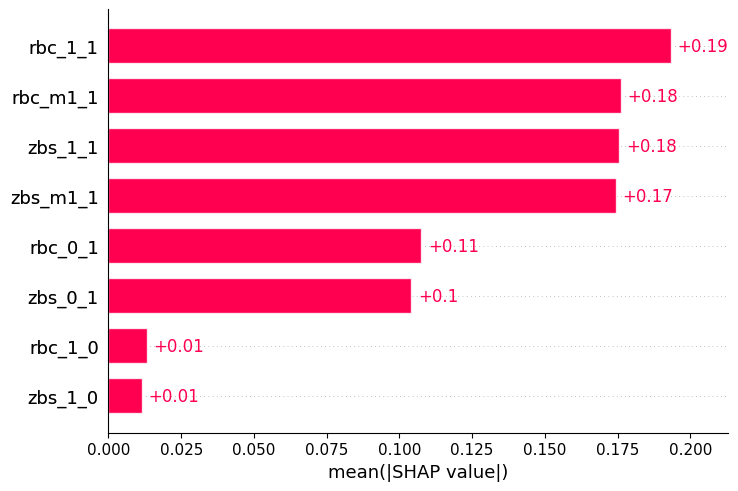

In [ ]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

In [ ]:

predicted_means = pred_params['concentration']
predicted_variances = pred_params['scale']

# Calculate standard deviation from variance
predicted_std = np.sqrt(predicted_variances)

# Calculate Mean Absolute Error (MAE) as one option for mean error
mean_error = np.mean(np.abs(predicted_means - Y_test))

# For Mean Squared Error (MSE), use:
# mean_squared_error = np.mean((predicted_means - Y_test) ** 2)

# Output the results
print(f"Mean Error (MAE): {mean_error}")
print(f"Standard Deviation: {predicted_std.mean()}")  # Average standard deviation across all predictions

# Note: The calculation of standard deviation's average might need adjustments based on your specific requirements.


Mean Error (MAE): 33.91252299381507
Standard Deviation: 5.30400276184082


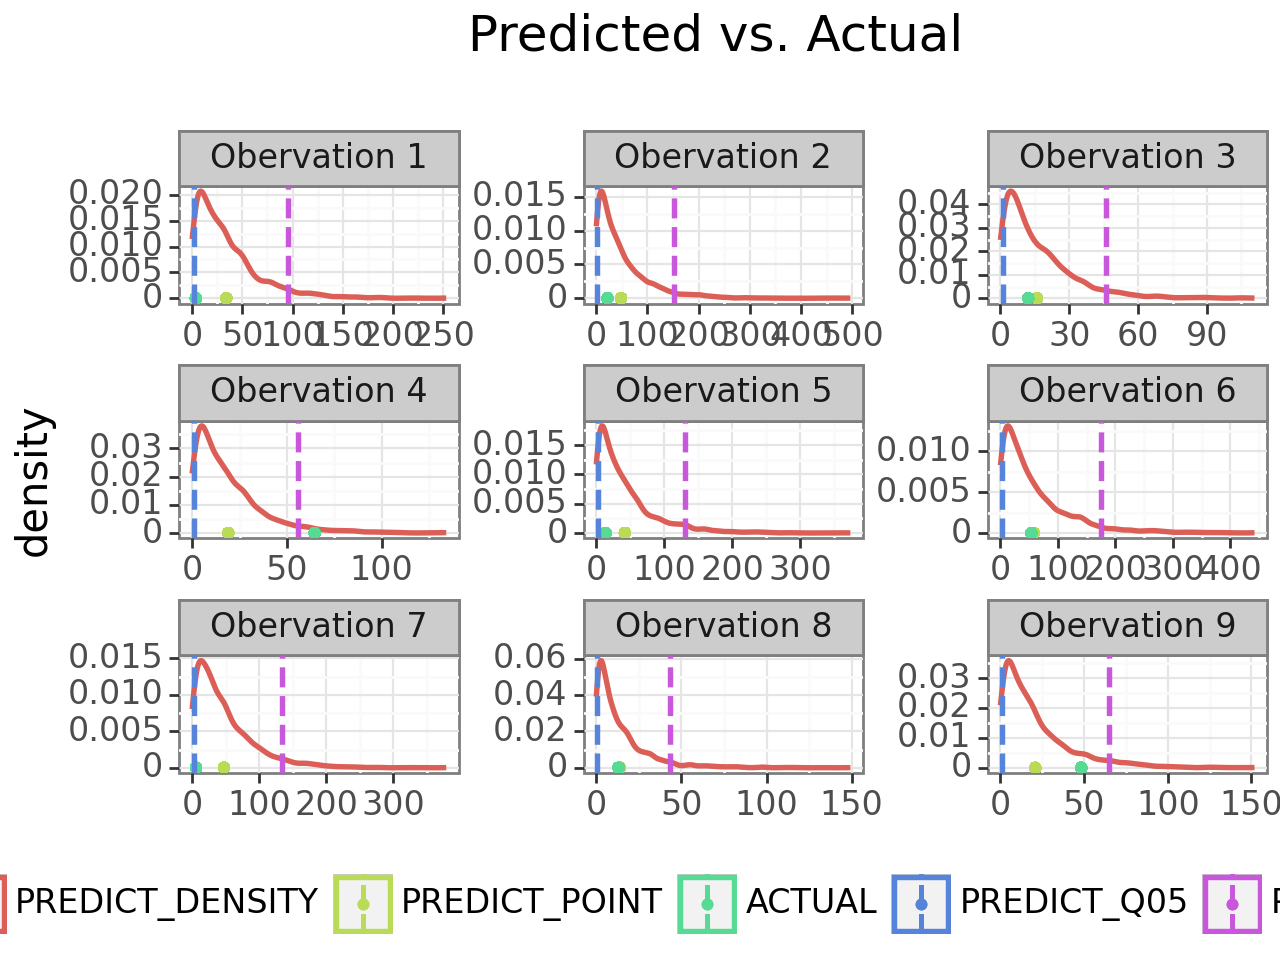

In [ ]:
from plotnine import ggplot, aes, geom_point, geom_vline, stat_density, facet_wrap, labs, theme_bw, scale_fill_brewer, theme, element_text, element_blank

y_pred = []

n_examples = 9

for i in range(n_examples):    
    y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
    y_samples["ACTUAL"] = Y_test.iloc[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=3) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          plot_title = element_text(hjust = 0.5),
          legend_title = element_blank()
         )
)

print(plot_pred)

UMAP WITH FEATURES AND MEAN ERROR

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


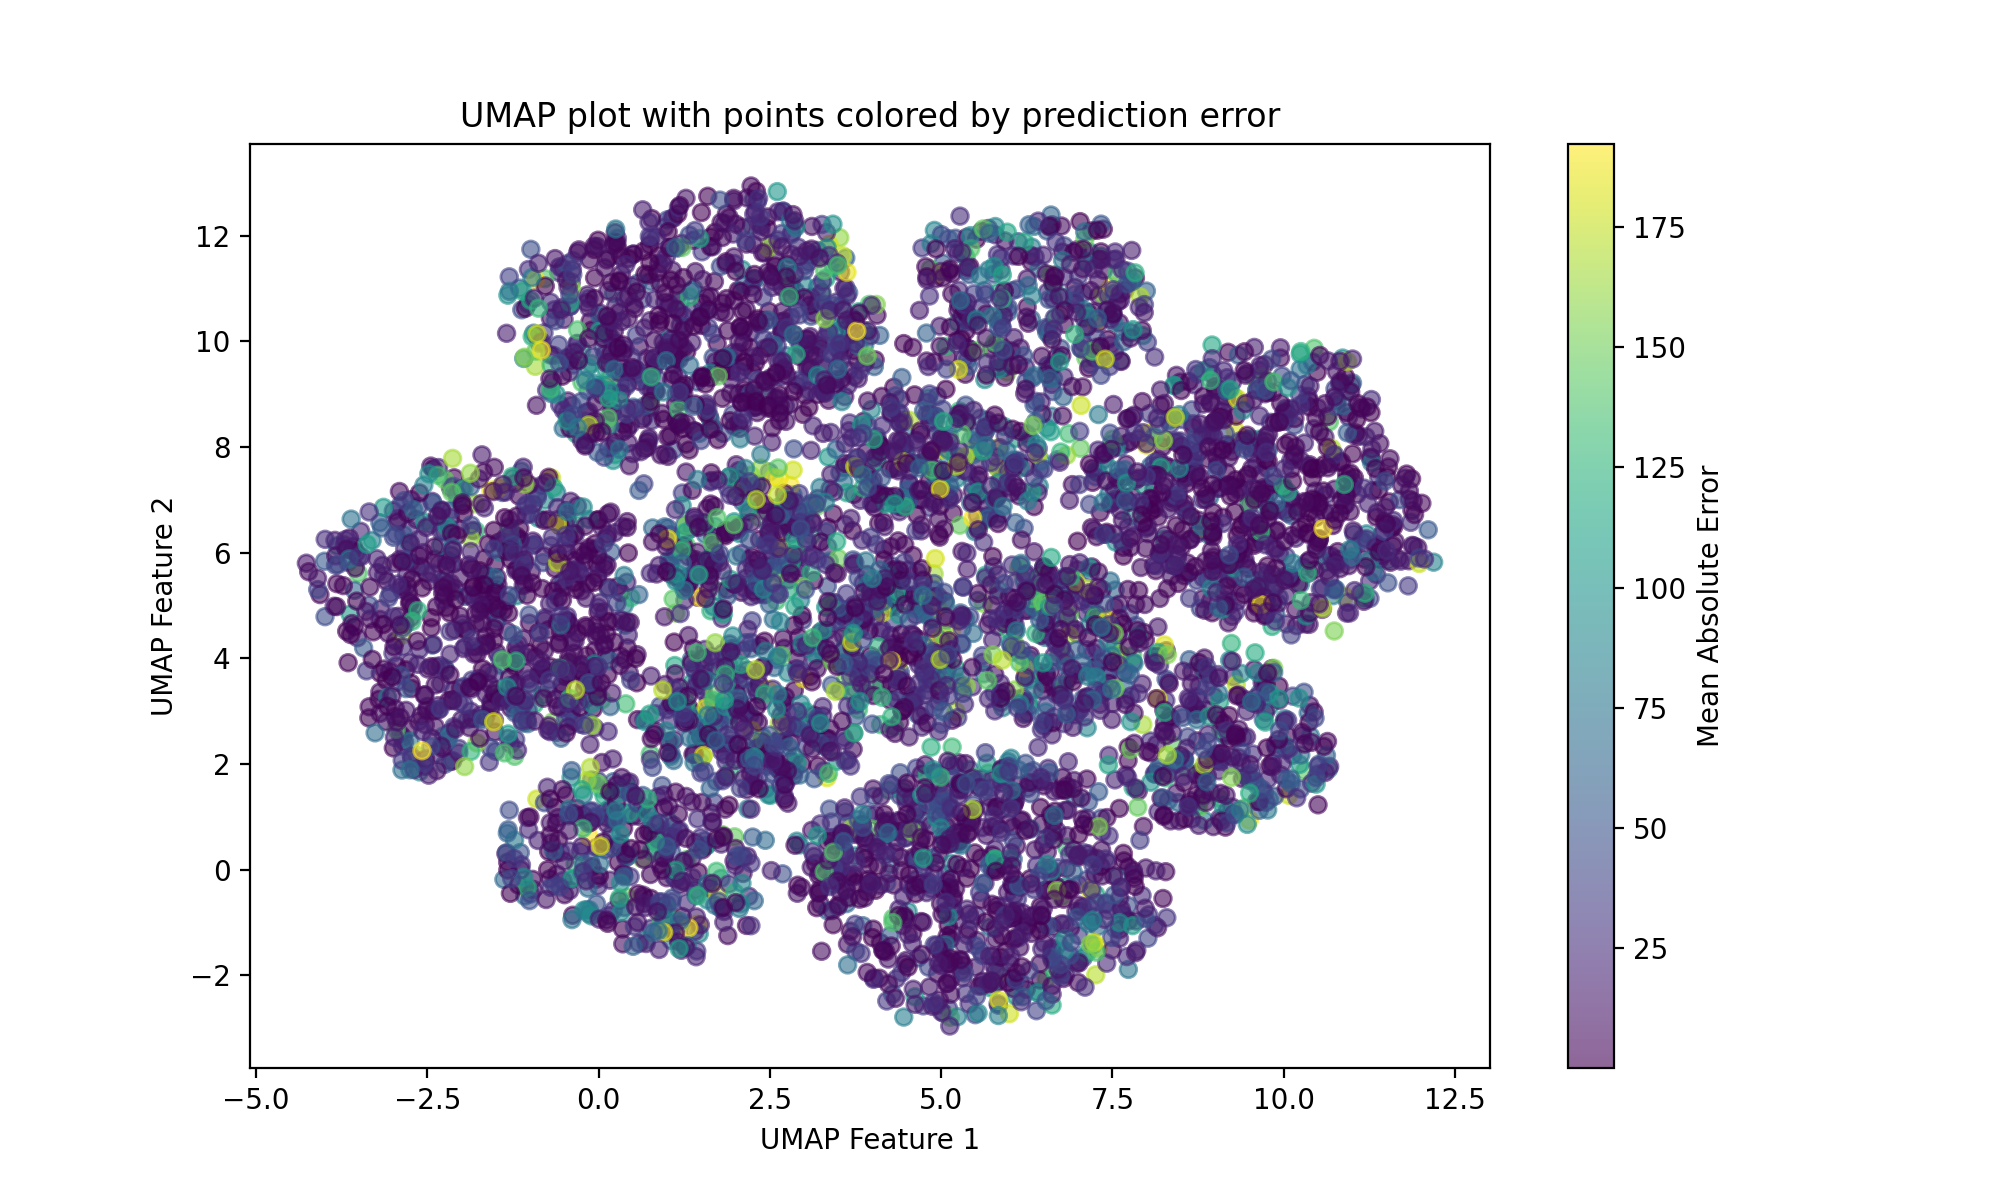

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = X_test.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH FEATURES AND STD

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


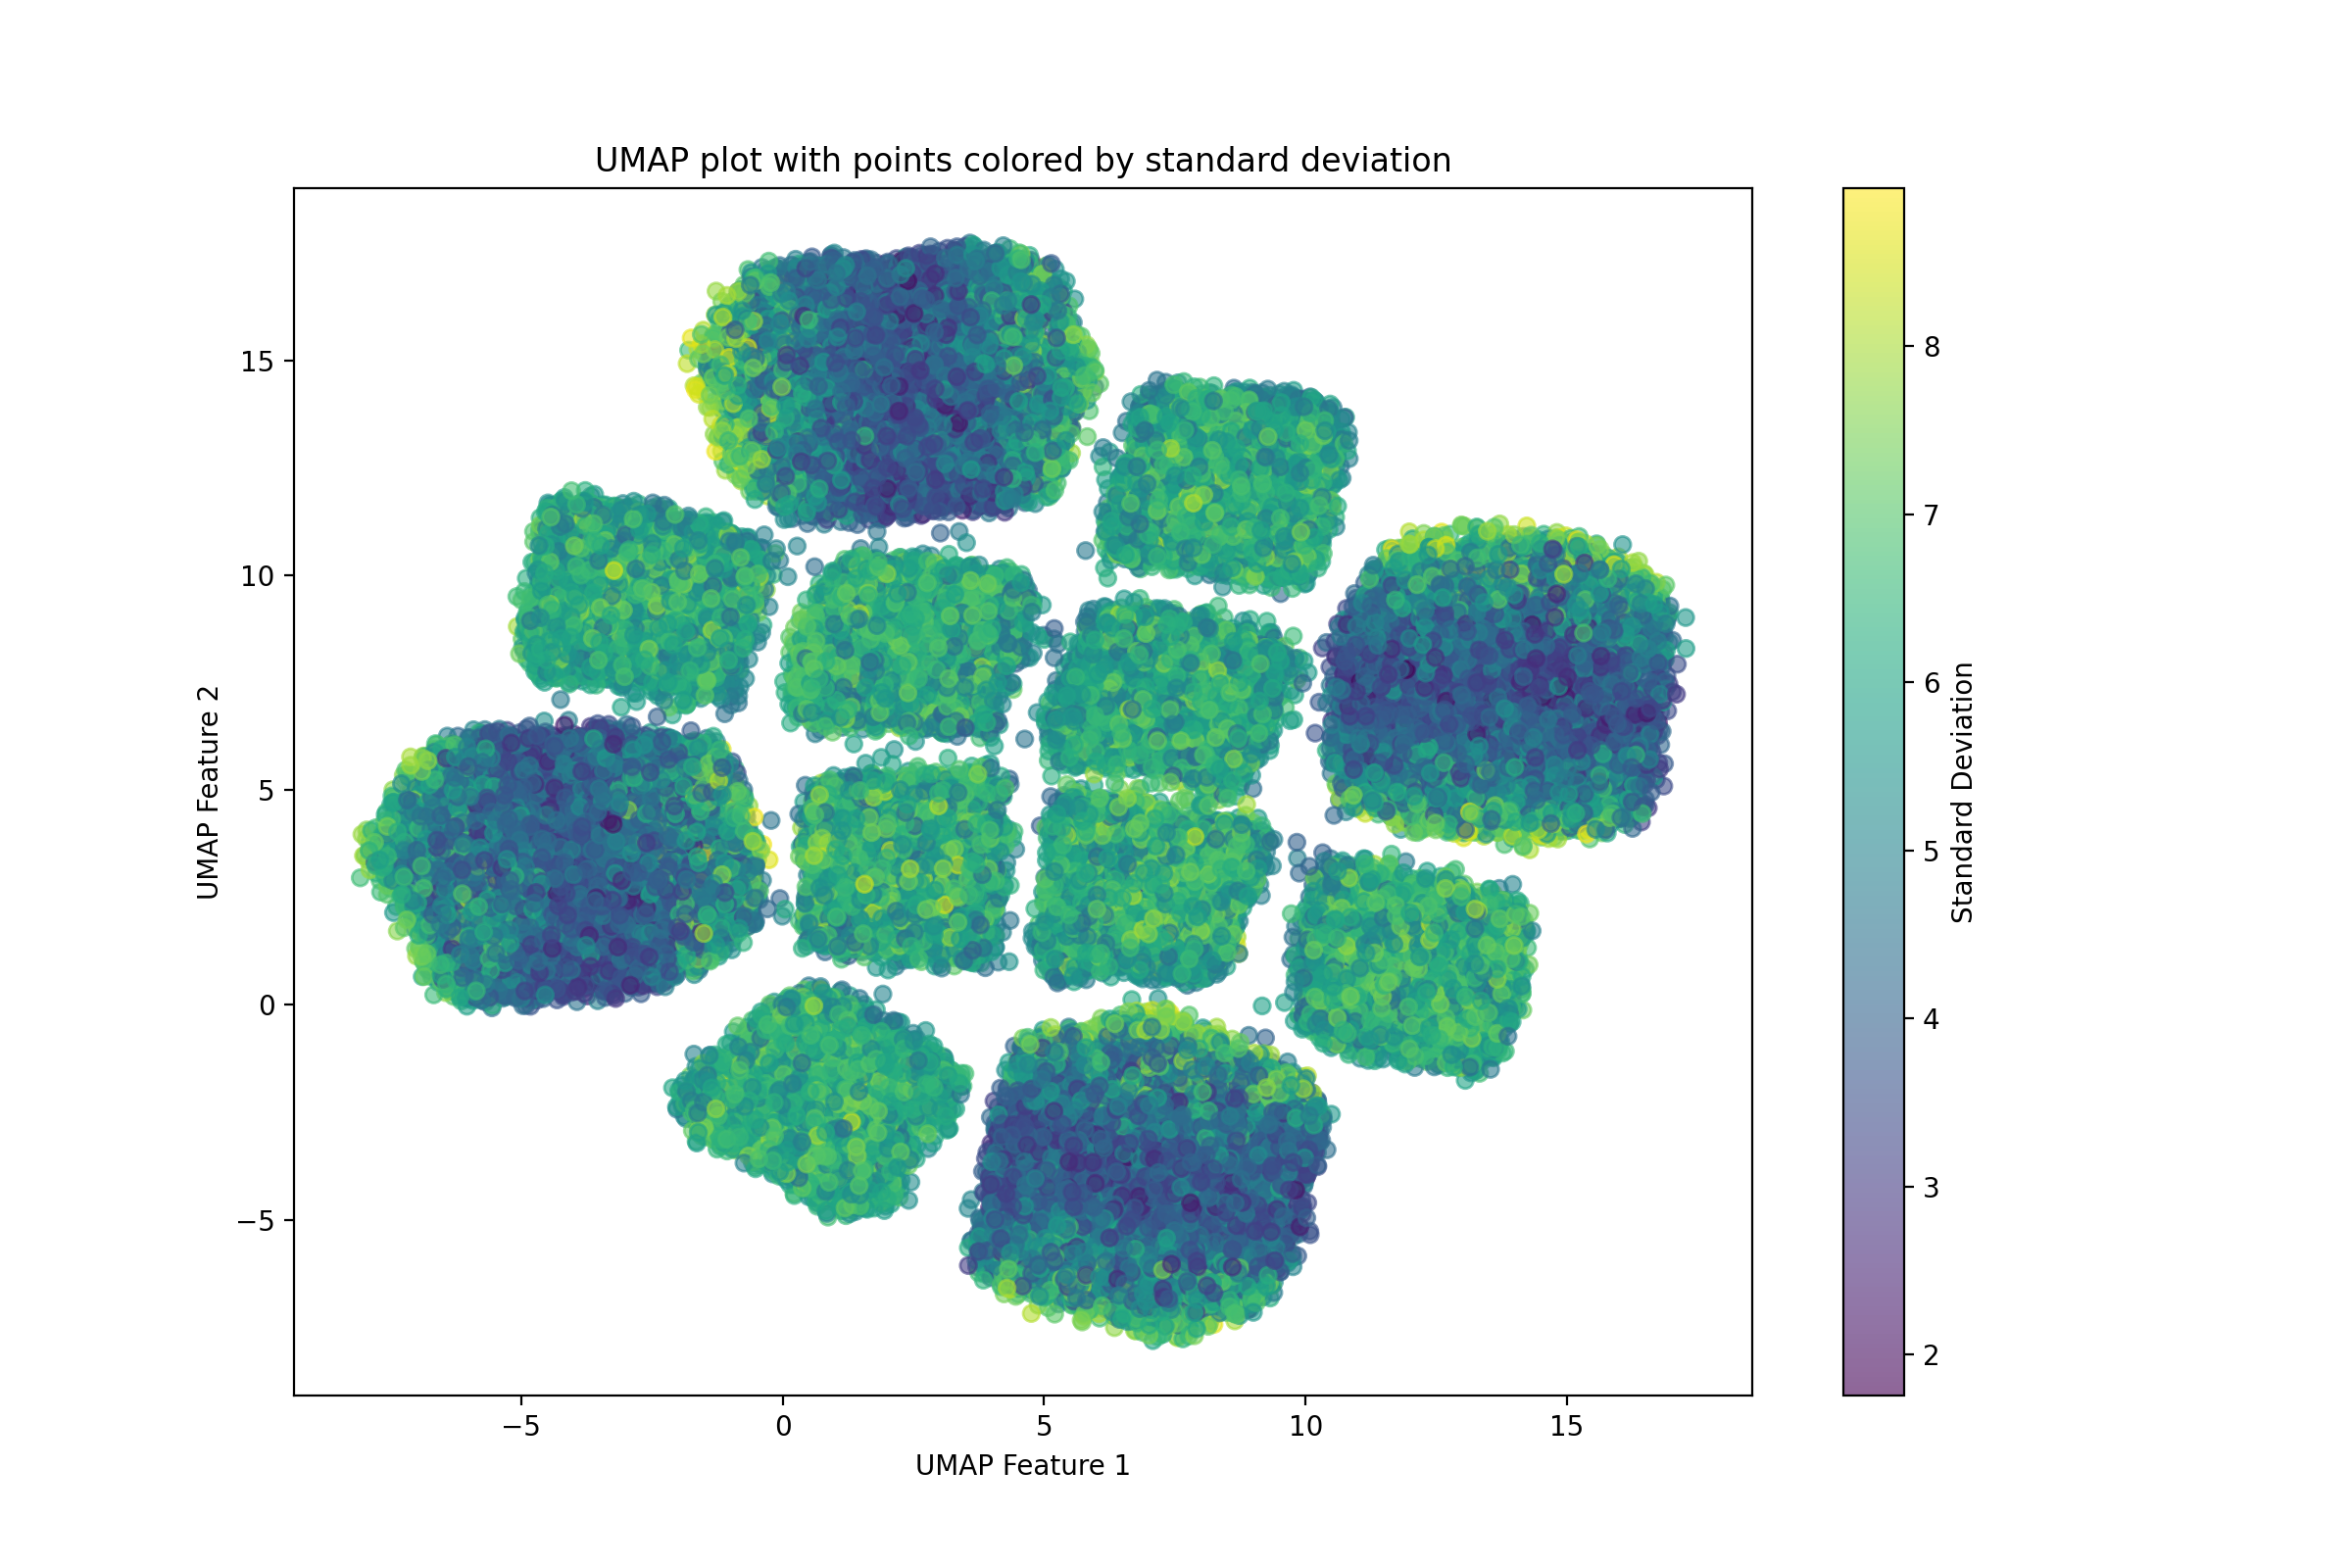

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Replace inf/-inf with NaN in your features
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any NaN values and handle them
if X_test.isnull().values.any():
    # Impute the NaNs or drop the rows/columns with NaN values.
    # Here we impute with the mean, but you might want to consider other imputation methods
    X_test = X_test.fillna(X_test.mean())

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Combine the scaled features and the standard deviations into one DataFrame for UMAP
umap_features = pd.DataFrame(X_test_scaled, columns=X_test.columns)
umap_features['std_dev'] = predicted_std

# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'std_dev' column)
embedding = reducer.fit_transform(umap_features.drop('std_dev', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND MEAN ERROR

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


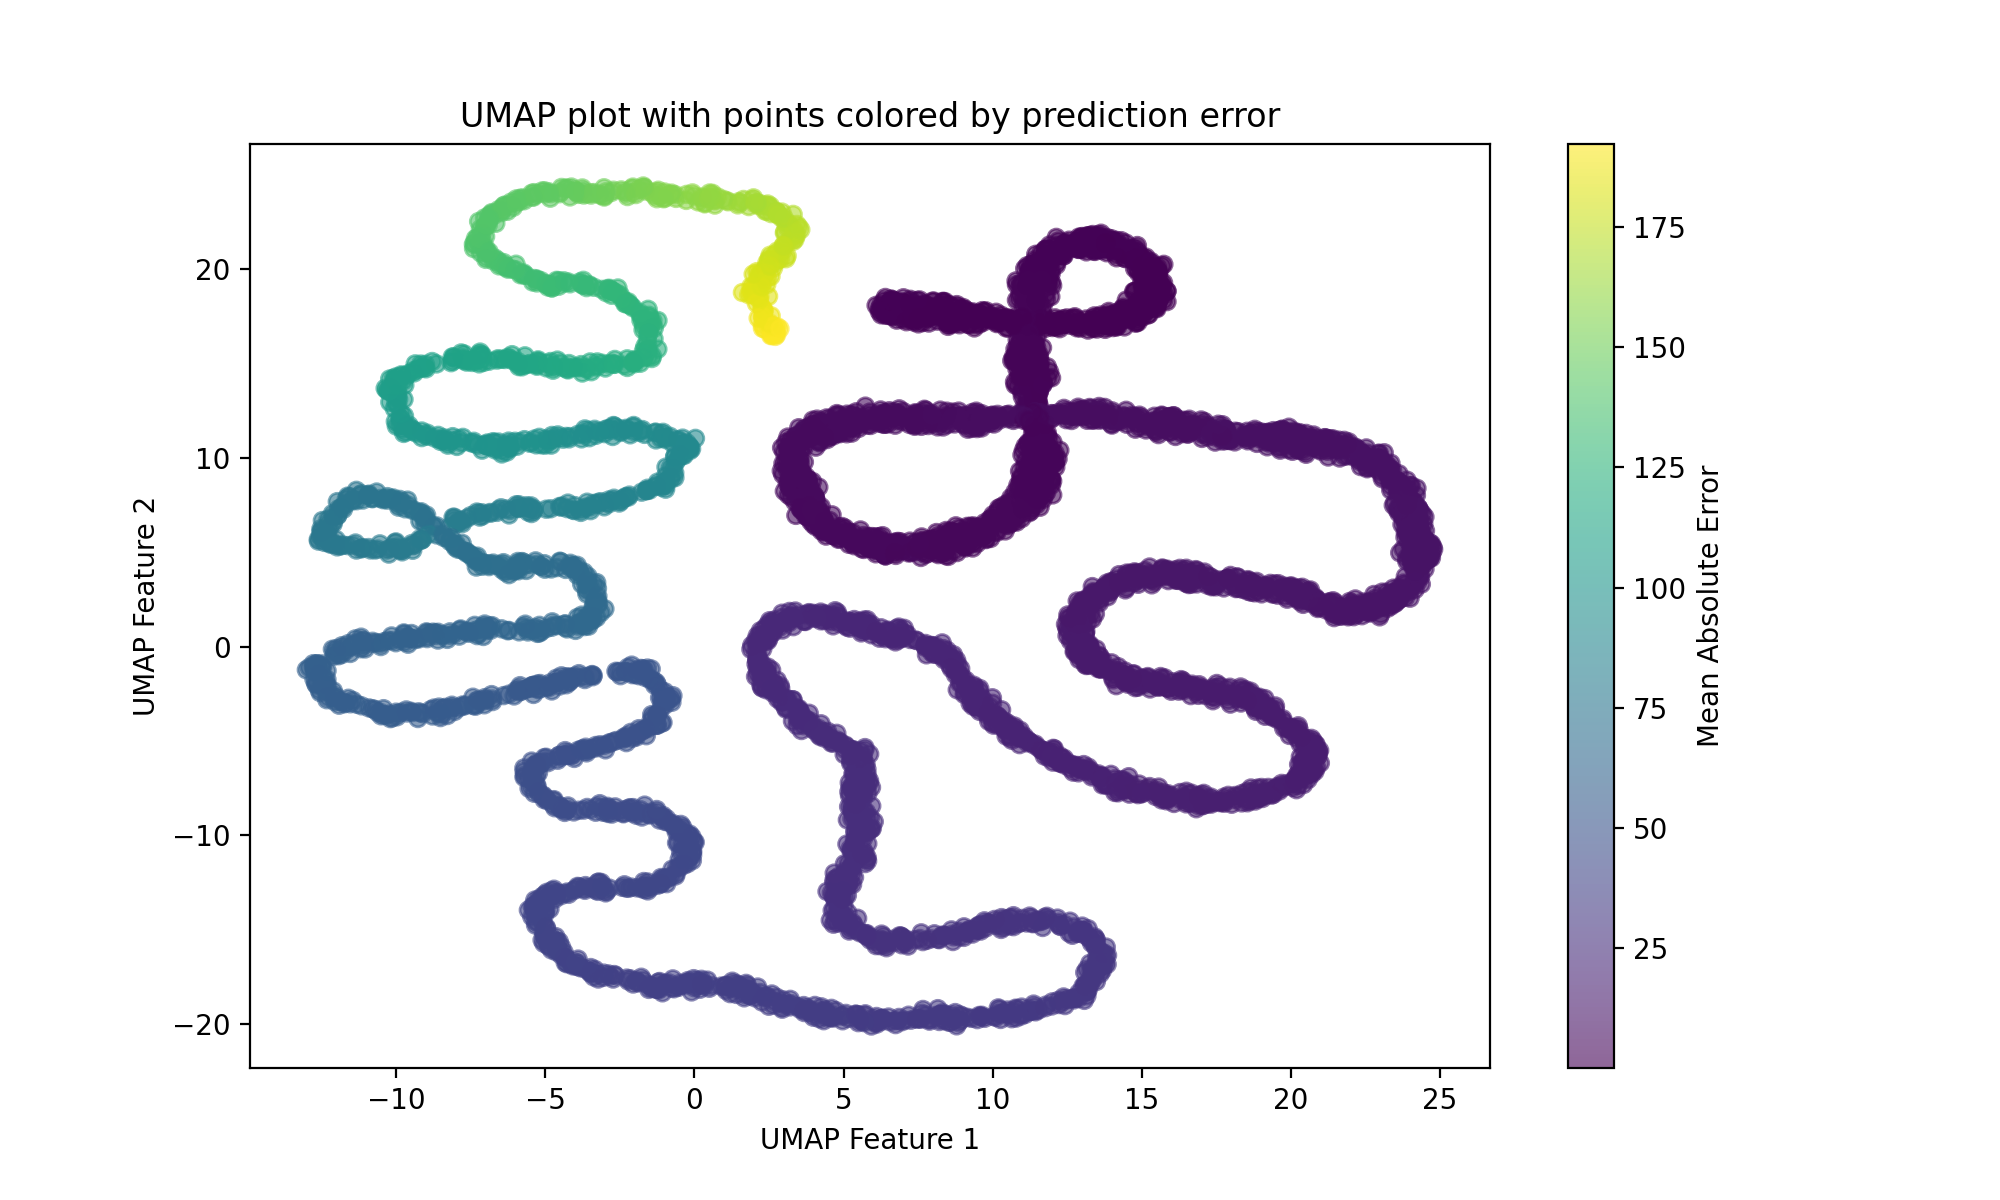

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)
f_t = pd.concat([X_test, Y_test], axis=1)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = f_t.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND STD

/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


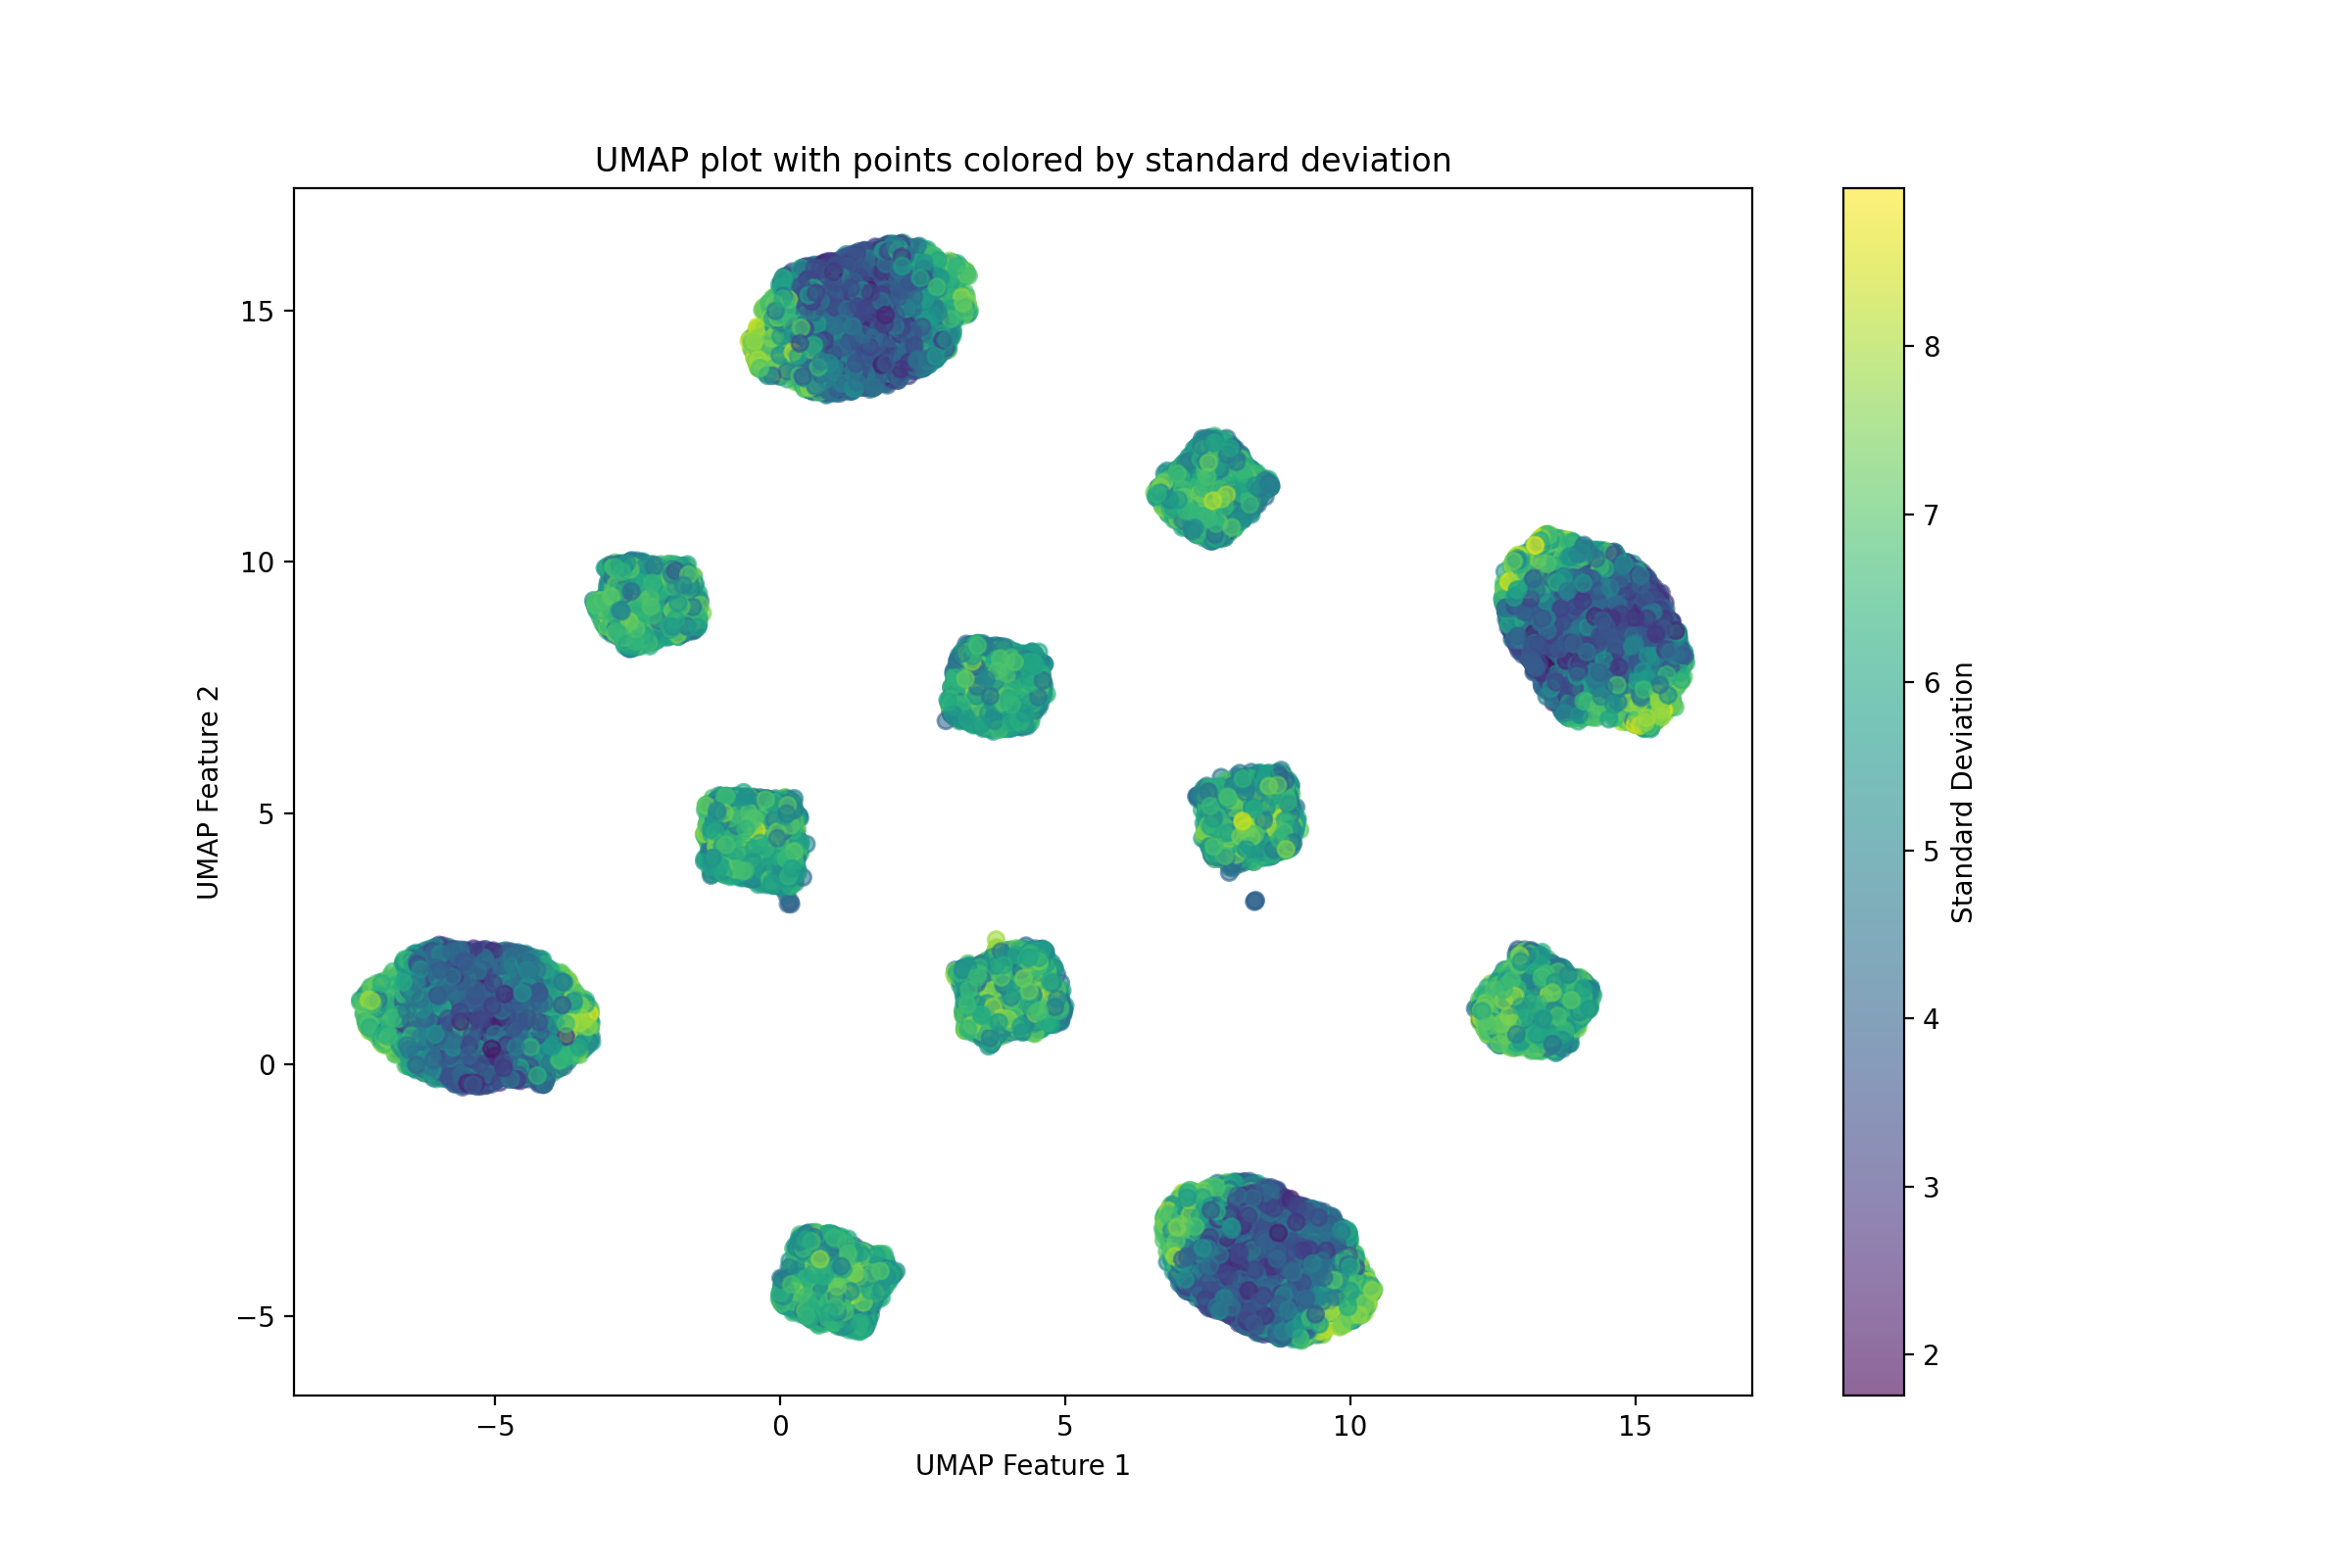

: 

In [ ]:
# Assuming `X_test` and `Y_test` are pandas DataFrames and `predicted_variances` is a numpy array

# Replace inf/-inf with NaN and then drop or impute NaN values for both X_test and Y_test
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Assuming you want to impute NaN values, do it for both
X_test = X_test.fillna(X_test.mean())
Y_test = Y_test.fillna(Y_test.mean())

# Combine X_test and Y_test into a single DataFrame
combined_data = pd.concat([X_test, Y_test], axis=1)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
combined_data_scaled = scaler.fit_transform(combined_data)

# Combine the scaled features into one DataFrame for UMAP
umap_features = pd.DataFrame(combined_data_scaled, columns=combined_data.columns)

# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the features
embedding = reducer.fit_transform(umap_features)

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Add standard deviation to the UMAP features for coloring the plot
umap_features['std_dev'] = predicted_std

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()
